In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Force JAX to use only CPU platforms
from jax import config
config.update("jax_enable_x64", True)  # turn on float64 globally
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt


# Objective function: |x1y1 -1| + |x2y1 - 1| + |x2y2 - 1|
def obj(x):
    return jnp.abs(x[0] * x[2] - 1) + jnp.abs(x[1] * x[2] - 1) + jnp.abs(x[1] * x[3] - 1)


single_value_and_grad = jax.value_and_grad(obj)
batched_value_and_grad = jax.vmap(single_value_and_grad)

@jax.jit(static_argnums=(1, 2, 3))
def run_all(x0s, K, alpha, beta):
    # x0s: (num_experiments, 4)
    def step(x, i):
        objs, grads = batched_value_and_grad(x)     # (N,), (N,4)
        norms = jnp.linalg.norm(x, axis=1)          # (N,)
        step_size = alpha / jnp.power(i + 1, beta)
        x_next = x - step_size * grads
        return x_next, (objs, norms)

    x_final, (objs_hist, norms_hist) = jax.lax.scan(
        step,
        x0s,
        jnp.arange(K)
    )
    # (K, N) -> (N, K) to match the original layout
    all_objs = objs_hist.T
    all_norms = norms_hist.T
    return all_objs, all_norms, x_final

K = 10**7
alpha = 0.1
beta = 0.501
num_experiments = 100

x0s = jnp.zeros((num_experiments, 4), dtype=jnp.float64)
for i in range(num_experiments):
    key = jax.random.PRNGKey(0 + i)
    x0s = x0s.at[i].set(jax.random.normal(key, (4,), dtype=jnp.float64))

all_objs, all_norms, x_final = run_all(x0s, K, alpha, beta)

bad_seeds = sum(all_objs[:, -1] > .9)

print(f"Number of experiments with unbounded iterates: {bad_seeds} out of {num_experiments}")

print(f"PRNGKey that leads to unbounded iterates:\n {jnp.where(all_objs[:, -1] > .9)[0]}")

Number of experiments with unbounded iterates: 13 out of 100
PRNGKey that leads to unbounded iterates:
 [ 1  5  6 13 38 40 44 47 51 54 76 85 98]


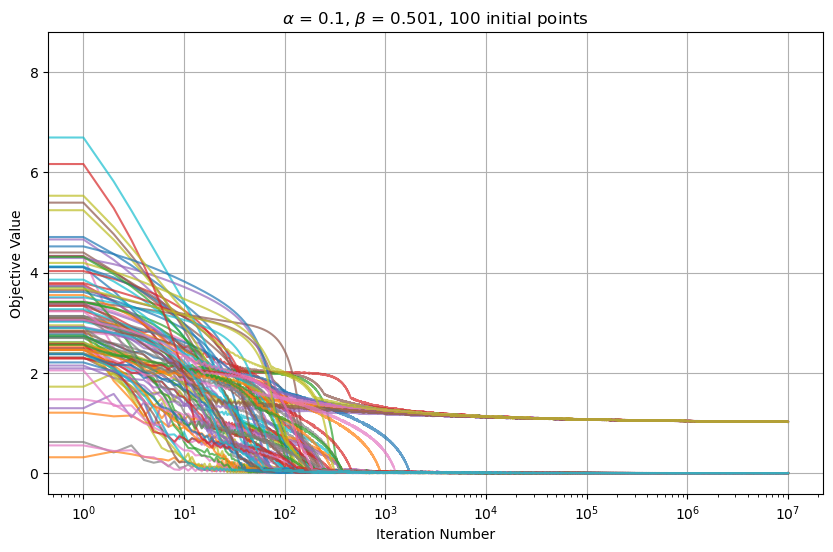

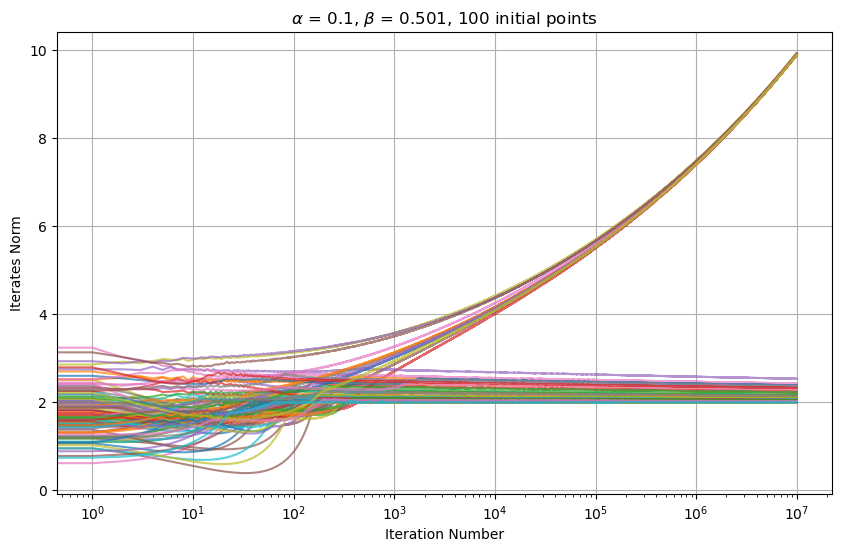

In [2]:
# Plot objective values for all experiments, this can take much longer time (~7mins v.s. 15s)
# than the previous block (algorithm run)
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(jnp.arange(K), all_objs.T, alpha=0.7)
ax1.set_title(f"$\\alpha$ = {alpha}, $\\beta$ = {beta}, {num_experiments} initial points")
ax1.set_xscale("log")
ax1.set_xlabel("Iteration Number")
ax1.set_ylabel("Objective Value")
ax1.grid(True)
fig1.savefig("fig3-obj.png", dpi=300)

fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(jnp.arange(K), all_norms.T, alpha=0.7) 
ax2.set_title(f"$\\alpha$ = {alpha}, $\\beta$ = {beta}, {num_experiments} initial points")
ax2.set_xscale("log")
ax2.set_xlabel("Iteration Number")
ax2.set_ylabel("Iterates Norm")
ax2.grid(True)
fig2.savefig("fig3-norms.png", dpi=300)

plt.show()

Initial x0: [-1.18428442 -0.11617041  0.17269028  0.95730718]


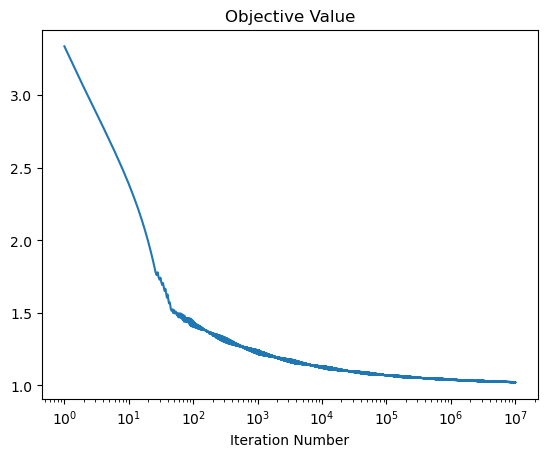

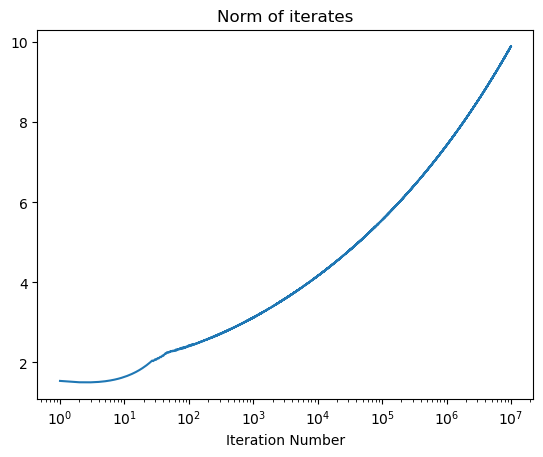

In [3]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Force JAX to use only CPU platforms

from jax import config
config.update("jax_enable_x64", True)  # turn on float64 globally

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

# ----- settings -----
# Reasonable settings (run ~5 mins) that show the desired behaviors are 
# 1. constant step sizes: beta = 0, (alpha, K) = (0.01, 1e7), (0.001, 1e8), (0.0001, 1e9)
# 2. nonsummable step sizes: beta = 0.501: (alpha, K) = (0.1, 1e7), (0.01, 1e8), (0.001, 1e9)
# 3. summable step sizes: beta = 1.001: (alpha, K) = (0.1, 1e9)
# You can try smaller alpha and increasing K if you have enough time and enough memory. 
K = 1 * 10**7 # number of iterations
alpha = 0.1 
beta = 0.501 

# ----- initial point -----
# you can change the seed here to [ 1  5  6 13 38 40 44 47 51 54 76 85 98] to see unbounded iterates
# so not all initial points lead to this, but it is definitely not an edge case (prob > 0.1). 
# also, many instances of matrix completion can have this phenomenon, this is not something pathological. 
key = jax.random.PRNGKey(1) 
x0 = jax.random.normal(key, (4,), dtype=jnp.float64) 
print("Initial x0:", x0)

# ----- objective -----
def obj(x):
    return (
        jnp.abs(x[0] * x[2] - 1.0) +
        jnp.abs(x[1] * x[2] - 1.0) +
        jnp.abs(x[1] * x[3] - 1.0)
    )

# 2) autodiff in float64
value_and_grad = jax.value_and_grad(obj)  # returns (value, grad)

@jax.jit
def run(x0):
    def step(x, i):
        val, grad = value_and_grad(x)
        norm = jnp.linalg.norm(x)
        step_size = alpha / jnp.power(i + 1, beta)
        x_next = x - step_size * grad
        return x_next, (val, norm)

    x_final, (objs_hist, norms_hist) = jax.lax.scan(
        step,
        x0,
        jnp.arange(K)
    )
    return objs_hist, norms_hist, x_final

# ----- run and plot -----
objs, norms, x_final = run(x0)

iters = jnp.arange(1, K + 1, dtype=jnp.int64)

plt.figure()
plt.plot(iters, objs)
plt.xscale("log")
plt.title("Objective Value")
plt.xlabel("Iteration Number")

plt.figure()
plt.plot(iters, norms)
plt.xscale("log")
plt.title("Norm of iterates")
plt.xlabel("Iteration Number")

plt.show()